use the spread 2Y and spread 5Y of swaps and take zscore of 1Y  
then take average between the 2 signals

# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX + ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2021-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
swaps = pd.read_csv("../../Dymon/Code Data/swaps.csv", index_col=0).iloc[2:]

In [5]:
swaps.columns = ["2Y", "5Y"]
swaps = swaps.astype(float)
swaps.index = pd.to_datetime(swaps.index)

In [6]:
spread_2y = swaps["2Y"]
spread_5y = swaps["5Y"]
spread_2y.index.name = "date"
spread_5y.index.name = "date"

# Data integrity

In [7]:
pd.concat([spread_2y.pipe(fill_date), spread_5y.pipe(fill_date)], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5645 entries, 2000-01-03 to 2021-08-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2Y      5644 non-null   float64
 1   5Y      5644 non-null   float64
dtypes: float64(2)
memory usage: 132.3 KB


<AxesSubplot:>

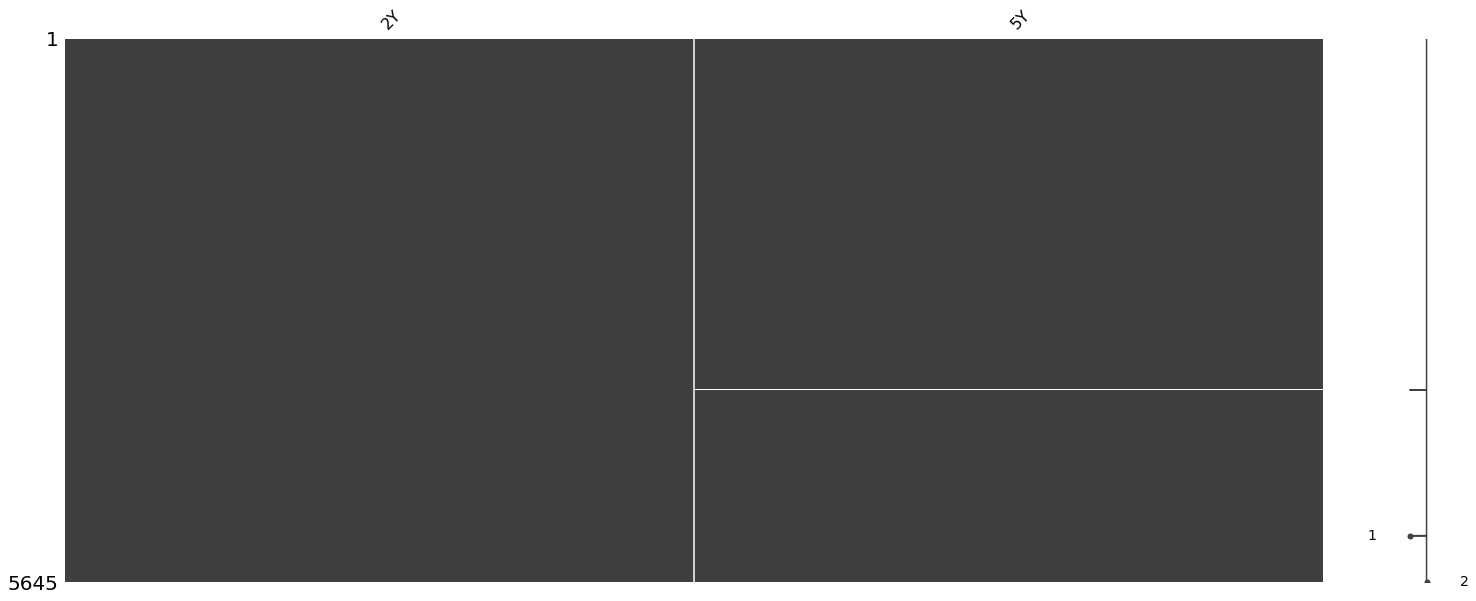

In [8]:
msmx(pd.concat([spread_2y.pipe(fill_date), spread_5y.pipe(fill_date)], axis=1))

# Signal

In [9]:
## 1Y zscore of 5Y swap spread, capped at 2
signal_5y = spread_5y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252, typ="median").pipe(cap_helper, 2)

## 1Y zscore of 2Y swap spread, capped at 2
signal_2y = spread_2y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252, typ="median").pipe(cap_helper, 2)

## Equal weighted average
signal = (signal_5y + signal_2y)/2

## Slow down using 5-day simple moving average
signal = signal.pipe(rolling_mean, 5)

sig = pd.concat([signal] * len(total_returns.columns), axis=1)
sig.columns = total_returns.columns
sig.index = pd.to_datetime(sig.index)

# Backtest Daily Rebal

In [10]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings, 
                    asset_groups={"ASIA":ASIA_FX, "G10":G10_FX})
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Sector scaling ...
    Grouping by [ASIA, G10]
Portfolio scaling ...
    Grouping by [ALL]


In [11]:
get_summary(daily_bt)

Returns   : 0.0417717213462779
Vol       : 0.10901231209310042
SR        : 0.3831835188543048
Max DD    : -40.73

C Returns : 0.036479981863247274
C SR      : 0.27996265597505543
C Max DD  : -34.83

Hit rate  : 0.507
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.03


In [12]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDCHF,USDCNH,USDEUR,USDGBP,USDIDR,USDINR,USDJPY,USDKRW,USDMYR,USDNOK,USDNZD,USDPHP,USDSEK,USDSGD,USDTHB,USDTWD
annualized_return,0.249767,0.160228,0.216828,0.062482,0.181422,-0.052305,0.275389,0.778851,0.205492,0.011528,0.39692,0.161761,0.128399,0.252768,0.128367,0.241203,0.648483,0.242061
sharpe,0.267278,0.168837,0.235582,0.064671,0.203509,-0.05879,0.21168,0.697315,0.227887,0.010646,0.367089,0.173866,0.137883,0.235388,0.145602,0.22526,0.576453,0.206791
dollar_sharpe,0.261995,0.164124,0.231117,0.046865,0.198097,-0.063111,0.208214,0.658976,0.223553,0.00519,0.35973,0.167554,0.1329,0.23583,0.140723,0.218282,0.572243,0.199505
trade_sharpe,0.267278,0.168837,0.235582,0.064671,0.203509,-0.05879,0.21168,0.697315,0.227887,0.010646,0.367089,0.173866,0.137883,0.235388,0.145602,0.22526,0.576453,0.206791
long_sharpe,0.027781,-0.00526,0.150499,-0.421952,0.108359,-0.326001,0.06098,0.184368,0.321109,-0.440932,0.072196,0.139978,-0.160738,-0.411032,0.15994,-0.178883,-0.146883,0.156239
short_sharpe,0.462649,0.300298,0.302799,0.783298,0.281641,0.139933,0.339416,1.143063,0.159793,0.358851,0.620207,0.200878,0.388206,0.847437,0.134539,0.550158,1.104817,0.245825
sortino,0.164359,0.102245,0.148787,0.038674,0.130569,-0.037166,0.120869,0.488807,0.144447,0.006872,0.224833,0.102292,0.085392,0.141064,0.088226,0.141044,0.33923,0.140532
max_drawdown,-3.090057,-2.927351,-2.891206,-4.191681,-2.713579,-6.028499,-3.011313,-3.338053,-2.766779,-5.820645,-4.580784,-3.583932,-3.283876,-6.968518,-2.670083,-3.901432,-5.635448,-5.242274
max_drawdown_start,2017-12-08,2019-02-01,2011-08-09,2016-11-23,2009-11-25,2003-06-17,2008-10-10,2011-08-01,2011-09-22,2004-05-10,2017-01-03,2019-01-30,2017-11-17,2002-07-22,2015-10-14,2016-12-22,2002-07-16,2002-07-17
max_drawdown_end,2020-03-19,2021-05-24,2014-06-30,2020-03-19,2012-07-24,2014-07-02,2008-10-27,2012-06-22,2014-07-17,2011-09-22,2020-03-23,2020-03-20,2021-02-24,2006-04-04,2020-03-19,2020-03-23,2004-03-25,2004-03-12


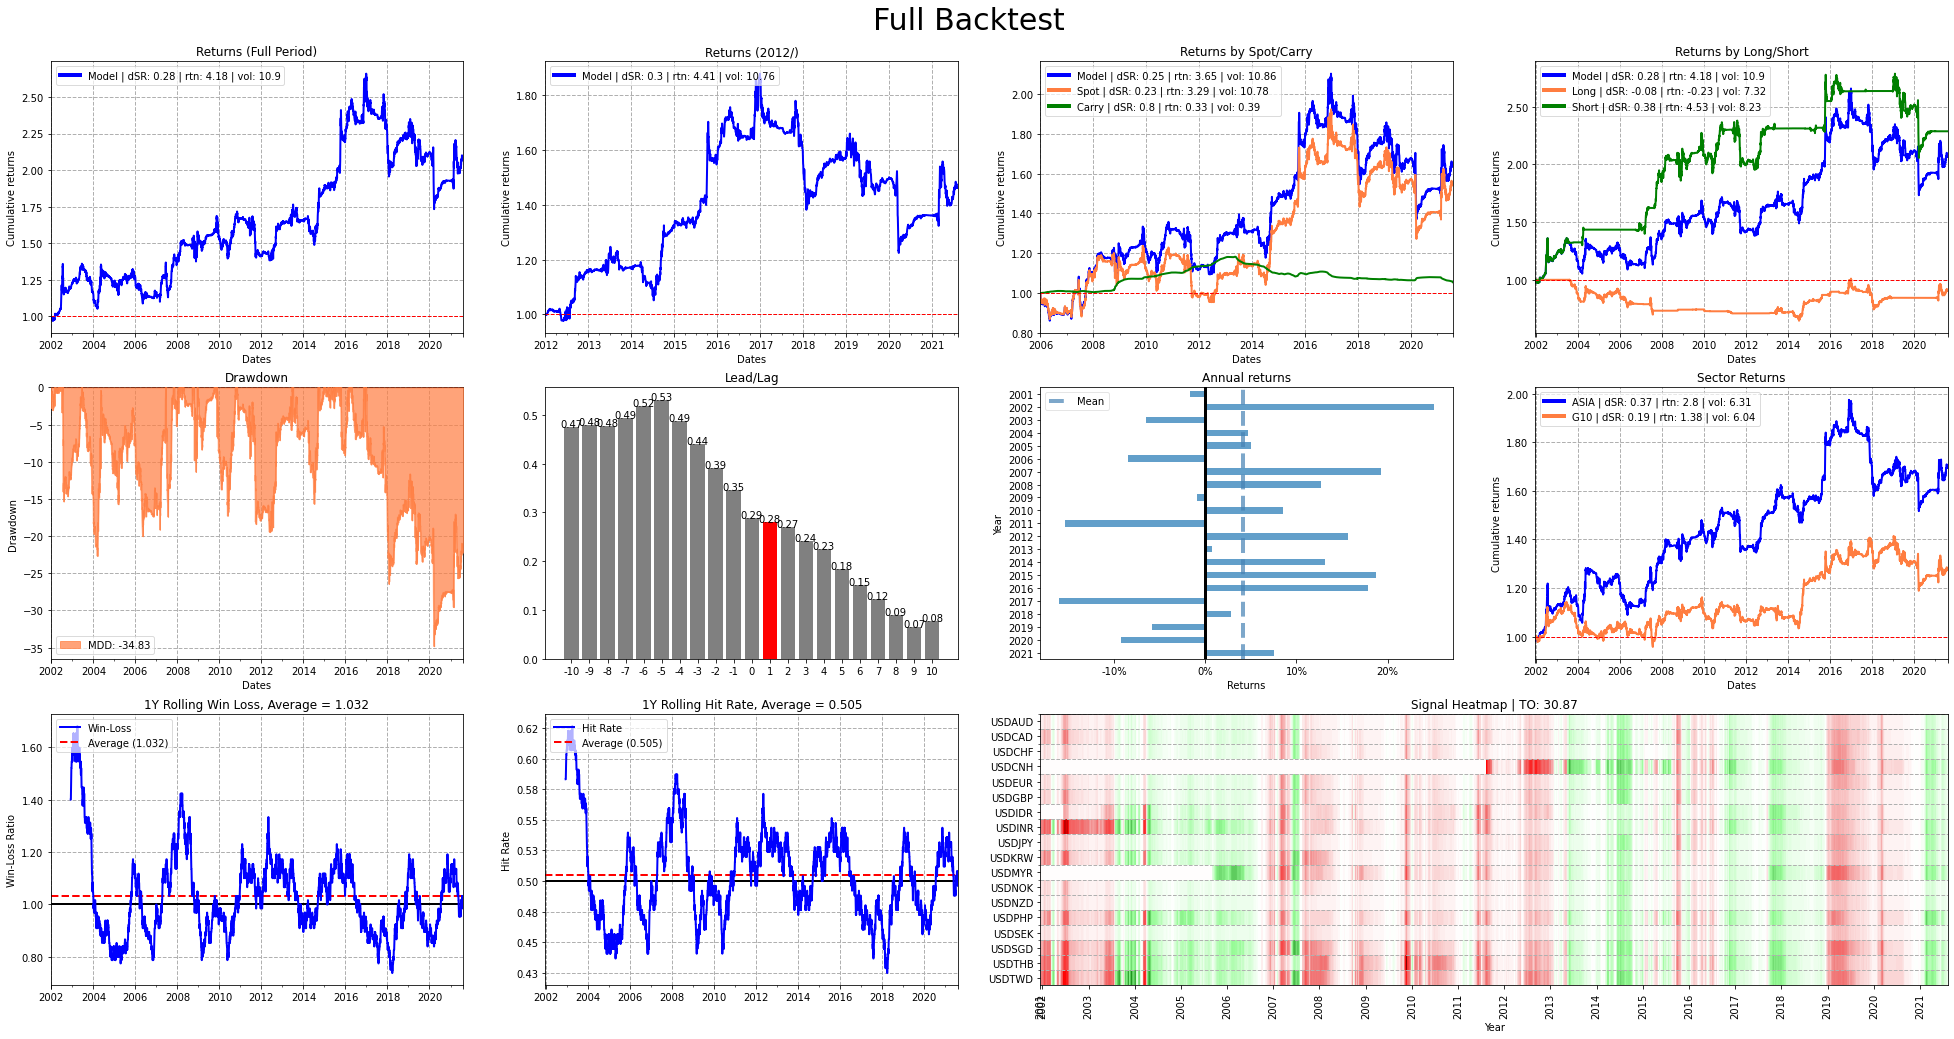

In [13]:
plot_bt2(daily_bt)

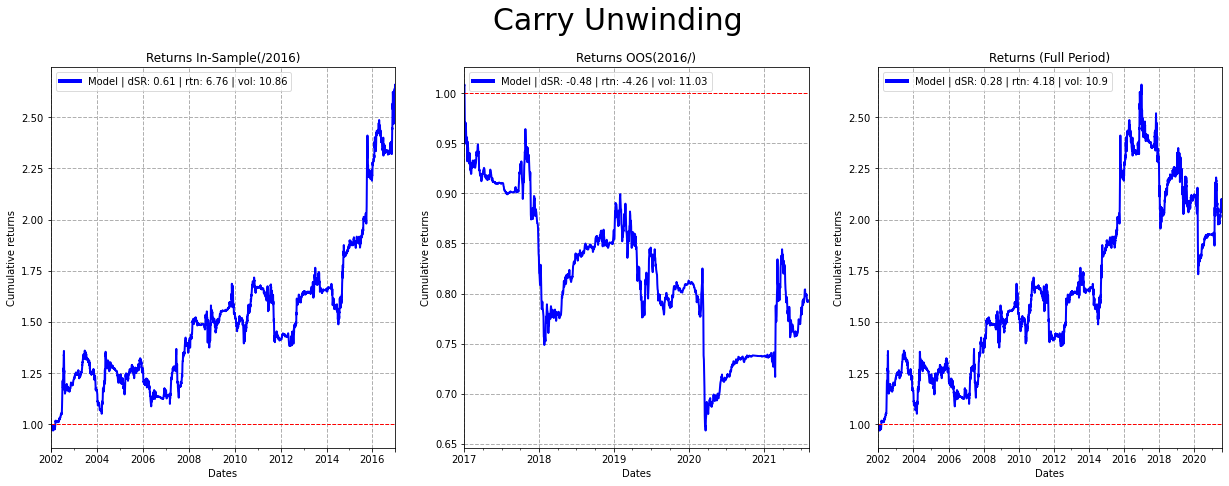

In [14]:
gs = GridSpec(nrows = 1, ncols = 3)
fig = plt.figure(figsize=(21, 7))
fig.suptitle(t="Carry Unwinding", fontsize=30, y=1)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(daily_bt.model_rtn[:"2016"], main = "Returns In-Sample(/2016)", compound=True))
fig.add_subplot(gs[1]).set_label(gen_plot_rtn(daily_bt.model_rtn["2017":], main = "Returns OOS(2016/)", compound=True))
fig.add_subplot(gs[2]).set_label(gen_plot_rtn(daily_bt.model_rtn, main = "Returns (Full Period)", compound=True))